#Практическая работа 1

##Выбор датасета
- Adult Census Income -- Социально емографические данные переписи США; задача предсказать уровень дохода
- Целевая переменная -- ```income (>50K$/≤50K$)```

##0. Загрузка данных

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"hermanpalchuk","key":"a5799fc0b9af5b9accde7d2cce0ca683"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d uciml/adult-census-income

Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income
License(s): CC0-1.0
adult-census-income.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip '/content/adult-census-income.zip' -d '/content/adult-census-income'

Archive:  /content/adult-census-income.zip
replace /content/adult-census-income/adult.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/adult-census-income/adult.csv  


##1. Анализ и подготовка данных

###1. Чтение данных

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/adult-census-income/adult.csv')

###2. Первичный анализ

In [ ]:
df.shape

(32561, 15)

In [ ]:
df.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education.num,int64
marital.status,object
occupation,object
relationship,object
race,object
sex,object


In [ ]:
# пропущенные значения
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


<Axes: xlabel='income', ylabel='count'>

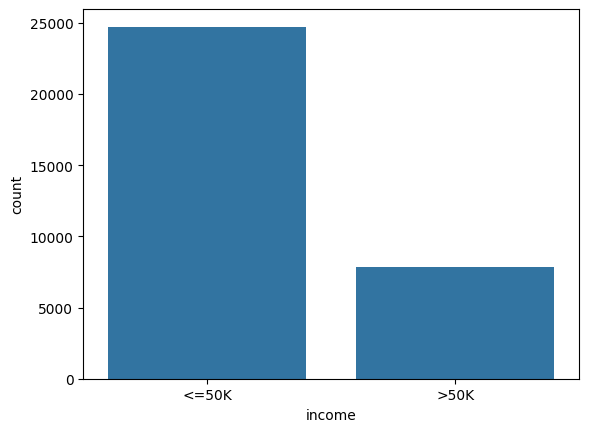

In [ ]:
# распределение целевой переменной
sns.countplot(x ='income', data = df)

In [ ]:
# Анализ категориальных признаков
df['income'].value_counts()

,count
income,
<=50K,24720
>50K,7841


###3. Разделение выборок

- Стратифицированное разделение на обучающую(70%), валидационную(15%) и тестовую(15%) выборки с помощью train_test_split с параметром stratify для сохранения распределения целевой переменной
- Сохранение тестовой выборки отдельно для финальной оценки

In [ ]:
from sklearn.model_selection import train_test_split


target = 'income'

X = df.drop(columns=target)
y = df[target]

# тестовая
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15,
                                                  stratify=y, random_state=42)

# на валидацию (15% от общего объема = 15 / 85)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176,
                                                  stratify=y_temp, random_state=42)

In [ ]:
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 22805
Validation size: 4871
Test size: 4885


In [ ]:
# сохранение
test_df = X_test.copy()
test_df[target] = y_test
test_df.to_csv('test_data.csv', index=False)

###4. Оцифровка данных

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
df = df.replace("?", pd.NA).dropna()

In [ ]:
# кодирование целевой
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [ ]:
# категориальные признаки
low_card_cat = ['workclass', 'education', 'marital.status', 'relationship', 'race', 'sex']
high_card_cat = ['occupation', 'native.country']

# числовые признаки
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

In [ ]:
# OneHotEncoder для признаков с небольшим числом категорий
low_card_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# OrdinalEncoder для признаков с большим числом категорий
high_card_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# числовые данные — просто заполним пропуски, если есть
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


# комбинируем в ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('low_cat', low_card_transformer, low_card_cat),
    ('high_cat', high_card_transformer, high_card_cat)
])

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fnlwgt', 'education.num',
                                  'capital.gain', 'capital.loss',
                                  'hours.per.week']),
                                ('low_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'education', 'marital.status',
                                  'relationship', 'race', 'sex']),
                                ('high_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['occupation', 'native.country'])])

In [ ]:
# преобразование
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

###5. Удаление ? (раньше сделано)

In [ ]:
df.isna().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


In [ ]:
# Числовые признаки
num_imputer = SimpleImputer(strategy='median')

# Категориальные: заполняем 'Unknown'
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

###6. Работа с выбросами

####Визуализация распределений числовых признаков с помощью boxplot

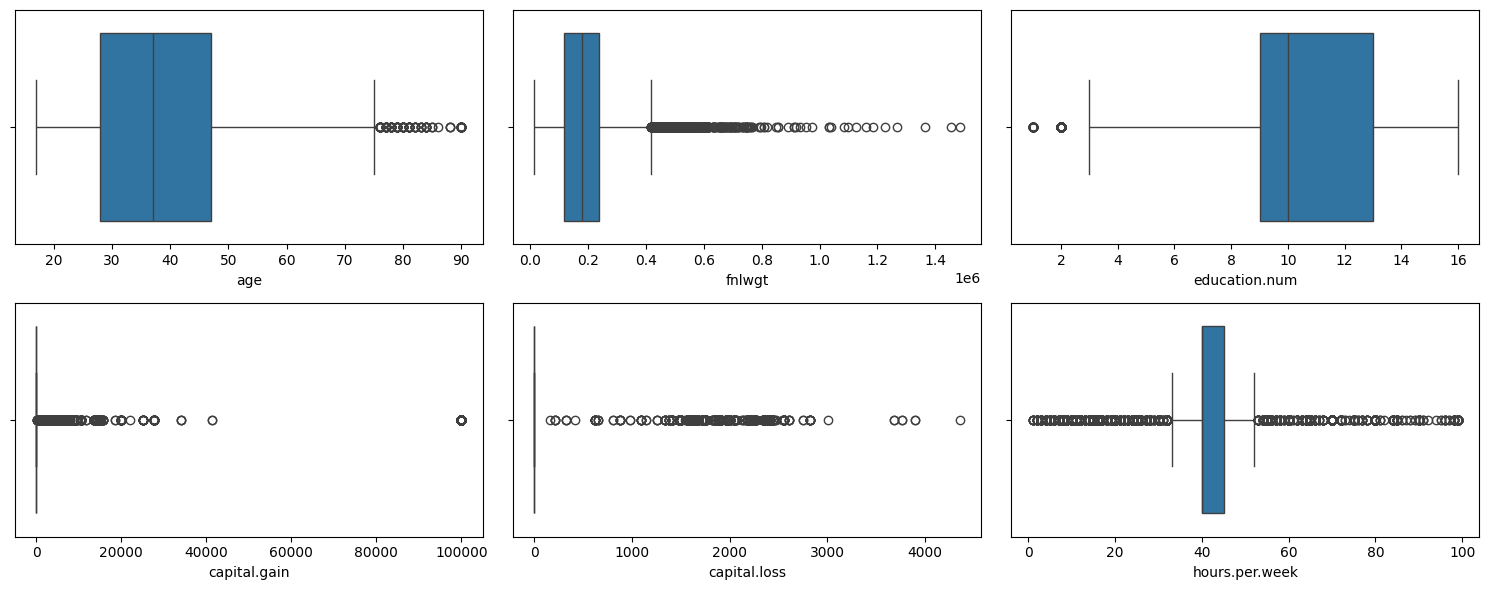

In [ ]:
import matplotlib.pyplot as plt


num_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

for i, col in enumerate(num_cols):
    row = i // 3
    col_idx = i % 3
    sns.boxplot(data=df, x=col, ax=axes[row, col_idx])


plt.tight_layout()
plt.show()

####Применение логарифмического преобразования для признаков с сильно скошенным распределением (capital-gain, capital-loss)

In [ ]:
# Сильно скошенные признаки
df['capital.gain'] = np.log1p(df['capital.gain'])
df['capital.loss'] = np.log1p(df['capital.loss'])

####Применение робастного масштабирования (RobustScaler) для уменьшения влияния выбросов

In [ ]:
from sklearn.preprocessing import RobustScaler


robust_scaler = RobustScaler()
df[num_cols] = robust_scaler.fit_transform(df[num_cols])

###7. Стандартизация/нормализация

####Применение StandardScaler для числовых признаков (age, fnlwgt,education-num capital-gain,capital-loss,hours-per-week)

In [ ]:
# from sklearn.preprocessing import StandardScaler


# standard_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
# scaler = StandardScaler()
# df[standard_cols] = scaler.fit_transform(df[standard_cols])

####Сохранение

In [ ]:
# import joblib


# joblib.dump(scaler, 'standard_scaler.pkl')

NameError: name 'scaler' is not defined

In [ ]:
# scaler = joblib.load('standard_scaler.pkl')
# X_test[standard_cols] = scaler.transform(X_test[standard_cols])

###Дополнительно

####Баланс классов

In [ ]:
df['income'].value_counts(normalize=True)

,proportion
income,
<=50K,0.751078
>50K,0.248922


#### Балансировка через SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE


# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_proc, y_train_enc)

In [ ]:
# print(pd.Series(y_resampled).value_counts())
# print(pd.Series(y_resampled).value_counts(normalize=True))

upd: результат ухудшился. поэтому SMOTE убрал + изначально соотношение примерно 3.1:1

In [ ]:
np.bincount(y_train_enc)

array([17313,  5492])

##1. Статистические тесты

In [ ]:
from scipy.stats import shapiro, ks_2samp, chi2_contingency, ttest_ind, mannwhitneyu

#### 1. Тест Шапиро-Уилка для capital.gain

In [ ]:
stat, p = shapiro(df['capital.gain'])
print(f"Stat={stat:.4f}, p={p:.4e}")

Stat=0.3195, p=1.1176e-136


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30162.
  res = hypotest_fun_out(*samples, **kwds)


--> capital.gain НЕ имеет нормального распределения

#### 2. Тест Колмогорова-Смирнова: capital.gain распределения по классам income

In [ ]:
group1 = df[df['income'] == '<=50K']['capital.gain']
group2 = df[df['income'] == '>50K']['capital.gain']
stat, p = ks_2samp(group1, group2)
print(f"Stat={stat:.4f}, p={p:.4e}")

Stat=0.1903, p=3.1739e-179


--> p << 0.05 — распределения capital.gain для групп <=50K и >50K статистически отличаются. Прибыль от капитала сильно влияет на различия между доходами

#####3. Тест хи-квадрат для education и income

In [ ]:
contingency_table = pd.crosstab(df['education'], df['income'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2={chi2:.2f}, p={p:.4e}")

Chi2=4070.38, p=0.0000e+00


--> p = 0 — сильная зависимость между уровнем образования и доходом

#####4. t-тест для возраста (age) между двумя классами income

In [ ]:
group1_age = df[df['income'] == '<=50K']['age']
group2_age = df[df['income'] == '>50K']['age']
stat, p = ttest_ind(group1_age, group2_age)
print(f"Stat={stat:.4f}, p={p:.4e}")

Stat=-43.3144, p=0.0000e+00


--> отрицательное значение указывает, что у группы <=50K средний возраст меньше, чем у >50K

####5. Тест Манна-Уитни для hours.per.week между двумя классами income

In [ ]:
group1_hours = df[df['income'] == '<=50K']['hours.per.week']
group2_hours = df[df['income'] == '>50K']['hours.per.week']
stat, p = mannwhitneyu(group1_hours, group2_hours)
print(f"Stat={stat}, p={p:.4e}")

Stat=56360558.5, p=0.0000e+00


--> p практически 0 — распределения количества рабочих часов в неделю у двух групп различаются

##2. Обучение машинных моделей и нахождение наиболее удачной

Для данного датасета:


**Baseline модели**
1. Dummy Classifier (стратегия most frequent)
2. Логистическая регрессия с базовыми параметрами
3. Дерево решений с базовыми параметрами


**Продвинутые классификаторы**
1. RandomForest
2. GradientBoosting (XGBoost,LightGBM,CatBoost)
3. Support Vector Machine с различными ядрами
4. NaiveBayes
5. K-Nearest Neighbors
6. Многослойный перцептрон (MLP)
7. Ансамблимоделей (Voting, Stacking)
8. Нейронные сети с различными архитектурами (Dense, Dropout)


**Методы перебора гиперпараметров**
1. GridSearchCV - полный перебор по сетке
2. RandomizedSearchCV - случайный поиск
3. Bayesian Optimization (BayesSearchCV)
4. Optuna-фреймвор для автоматической оптимизации
5. Keras Tuner для нейронных сетей


**Методы сравнения моделей**
1. Кросс-валидация (k-fold, stratified)
2. Сравнение кривых обучения
3. Сравнение ROC-кривых и PR-кривых
4. Статистические тесты (McNemar, t-тест)
5. Анализ важности признаков
6. Анализ ошибок классификации


**Метрики**
1. Accuracy
2. Precision, Recall, F1-score
3. ROC AUC
4. Confusion Matrix
5. Log Loss

###Baseline модели

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


results = {}

# Dummy Classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_proc, y_train_enc)
dummy_score = dummy.score(X_test_proc, y_test_enc)
print("Dummy Classifier accuracy:", dummy_score)
results["Dummy Classifier"] = dummy_score

# Логистическая регрессия
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
logreg.fit(X_train_proc, y_train_enc)
logreg_score = logreg.score(X_test_proc, y_test_enc)
print("LogReg accuracy:", logreg_score)
results["Logistic Regression"] = logreg_score

# Дерево решений с базовыми параметрами
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train_proc, y_train_enc)
tree_score = tree.score(X_test_proc, y_test_enc)
print("Decision Tree accuracy:", tree_score)
results["Decision Tree"] = tree_score

Dummy Classifier accuracy: 0.7592630501535312
LogReg accuracy: 0.8018423746161719
Decision Tree accuracy: 0.8131013306038894


###Продвинутые классификаторы

In [ ]:
!pip install xgboost lightgbm catboost

Преобразование выхода в плотный массив numpy

In [ ]:
X_train_proc = X_train_proc.toarray()
X_val_proc = X_val_proc.toarray()
X_test_proc = X_test_proc.toarray()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}

other_models = {
    "SVM (RBF kernel)": SVC(kernel='rbf', probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=300, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_proc, y_train_enc)
    score = model.score(X_test_proc, y_test_enc)
    print(f"{name} accuracy: {score:.4f}")
    results[name] = score

for name, model in other_models.items():
    model.fit(X_train_proc, y_train_enc)
    score = model.score(X_test_proc, y_test_enc)
    print(f"{name} accuracy: {score:.4f}")
    results[name] = score

Random Forest accuracy: 0.8508
Gradient Boosting accuracy: 0.8628


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:58:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost accuracy: 0.8684
[LightGBM] [Info] Number of positive: 5492, number of negative: 17313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 22805, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240824 -> initscore=-1.148165
[LightGBM] [Info] Start training from score -1.148165


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM accuracy: 0.8725
CatBoost accuracy: 0.8712
SVM (RBF kernel) accuracy: 0.8420
Naive Bayes accuracy: 0.6344
K-Nearest Neighbors accuracy: 0.8297
MLP accuracy: 0.8225


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.4f}")

LightGBM: 0.8725
CatBoost: 0.8712
XGBoost: 0.8684
Gradient Boosting: 0.8628
Random Forest: 0.8508
SVM (RBF kernel): 0.8420
K-Nearest Neighbors: 0.8297
MLP: 0.8225
Decision Tree: 0.8131
Logistic Regression: 0.8018
Dummy Classifier: 0.7593
Naive Bayes: 0.6344


###Ансамбли

VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
        ('xgboost', XGBClassifier(eval_metric='logloss', random_state=42)),
        ('lightgbm', LGBMClassifier(random_state=42)),
        ('gradboost', GradientBoostingClassifier(random_state=42))
    ],
    voting='soft'
)

voting_clf.fit(X_train_proc, y_train_enc)
voting_score = voting_clf.score(X_test_proc, y_test_enc)
print(f"Voting Classifier accuracy: {voting_score:.4f}")
results['Voting Classifier'] = voting_score

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5492, number of negative: 17313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 22805, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240824 -> initscore=-1.148165
[LightGBM] [Info] Start training from score -1.148165


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Voting Classifier accuracy: 0.8700


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5492, number of negative: 17313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 22805, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240824 -> initscore=-1.148165
[LightGBM] [Info] Start training from score -1.148165
Voting Classifier accuracy: 0.8700


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


StackingClassifier

In [ ]:
stacking_clf = StackingClassifier(
    estimators=[
        ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
        ('xgboost', XGBClassifier(eval_metric='logloss', random_state=42)),
        ('lightgbm', LGBMClassifier(random_state=42)),
        ('gradboost', GradientBoostingClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)

stacking_clf.fit(X_train_proc, y_train_enc)
stacking_score = stacking_clf.score(X_test_proc, y_test_enc)
print(f"Stacking Classifier accuracy: {stacking_score:.4f}")
results['Stacking Classifier'] = stacking_score

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5492, number of negative: 17313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 22805, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240824 -> initscore=-1.148165
[LightGBM] [Info] Start training from score -1.148165


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4394, number of negative: 13850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 18244, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240846 -> initscore=-1.148045
[LightGBM] [Info] Start training from score -1.148045


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4394, number of negative: 13850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 18244, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240846 -> initscore=-1.148045
[LightGBM] [Info] Start training from score -1.148045


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4394, number of negative: 13850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 18244, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240846 -> initscore=-1.148045
[LightGBM] [Info] Start training from score -1.148045


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4393, number of negative: 13851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 18244, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240791 -> initscore=-1.148345
[LightGBM] [Info] Start training from score -1.148345


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4393, number of negative: 13851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 18244, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240791 -> initscore=-1.148345
[LightGBM] [Info] Start training from score -1.148345


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Classifier accuracy: 0.8712


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.4f}")

LightGBM: 0.8725
CatBoost: 0.8712
Stacking Classifier: 0.8712
Voting Classifier: 0.8700
XGBoost: 0.8684
Gradient Boosting: 0.8628
Random Forest: 0.8508
SVM (RBF kernel): 0.8420
K-Nearest Neighbors: 0.8297
MLP: 0.8225
Decision Tree: 0.8131
Logistic Regression: 0.8018
Dummy Classifier: 0.7593
Naive Bayes: 0.6344


In [ ]:
!pip install optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
for name, model in models_cv.items():
    if name not in ["LightGBM (Optuna)", "Stacking Classifier", "Voting Classifier"]:
        model.fit(X_train_proc, y_train_enc)

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train_proc, y_train_enc, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial params:", study.best_trial.params)
print("Best CV accuracy:", study.best_trial.value)

best_catboost = CatBoostClassifier(**study.best_trial.params)
best_catboost.fit(X_train_proc, y_train_enc)

test_score = best_catboost.score(X_test_proc, y_test_enc)
print(f"CatBoost (Optuna-tuned) test accuracy: {test_score:.4f}")

results["CatBoost (Optuna)"] = test_score

[I 2025-06-01 20:05:01,203] A new study created in memory with name: no-name-6837be5a-5309-42fb-92cf-bf2428a81efa
[I 2025-06-01 20:05:07,128] Trial 0 finished with value: 0.8716071032115519 and parameters: {'iterations': 448, 'depth': 6, 'learning_rate': 0.056209507505240904, 'l2_leaf_reg': 6.544415751028603}. Best is trial 0 with value: 0.8716071032115519.
[I 2025-06-01 20:05:14,052] Trial 1 finished with value: 0.8683182411264859 and parameters: {'iterations': 389, 'depth': 7, 'learning_rate': 0.12069325782966166, 'l2_leaf_reg': 1.2353457704929536}. Best is trial 0 with value: 0.8716071032115519.
[I 2025-06-01 20:05:24,135] Trial 2 finished with value: 0.8647664345987698 and parameters: {'iterations': 470, 'depth': 8, 'learning_rate': 0.012019816095075655, 'l2_leaf_reg': 7.2584767237376155}. Best is trial 0 with value: 0.8716071032115519.
[I 2025-06-01 20:05:29,116] Trial 3 finished with value: 0.8704669715855363 and parameters: {'iterations': 418, 'depth': 5, 'learning_rate': 0.0859

Best trial params: {'iterations': 356, 'depth': 4, 'learning_rate': 0.11858770433110749, 'l2_leaf_reg': 6.033183647069916}
Best CV accuracy: 0.8723525614651454
0:	learn: 0.5879295	total: 4.44ms	remaining: 1.58s
1:	learn: 0.5121297	total: 8.59ms	remaining: 1.52s
2:	learn: 0.4624522	total: 12.8ms	remaining: 1.5s
3:	learn: 0.4274124	total: 17ms	remaining: 1.5s
4:	learn: 0.4047094	total: 20.9ms	remaining: 1.46s
5:	learn: 0.3898926	total: 25ms	remaining: 1.46s
6:	learn: 0.3812261	total: 29.2ms	remaining: 1.45s
7:	learn: 0.3689664	total: 33.3ms	remaining: 1.45s
8:	learn: 0.3593198	total: 37.3ms	remaining: 1.44s
9:	learn: 0.3510886	total: 41.2ms	remaining: 1.43s
10:	learn: 0.3444894	total: 45.1ms	remaining: 1.42s
11:	learn: 0.3392349	total: 49ms	remaining: 1.4s
12:	learn: 0.3364213	total: 52.8ms	remaining: 1.39s
13:	learn: 0.3340543	total: 56.8ms	remaining: 1.39s
14:	learn: 0.3312381	total: 60.7ms	remaining: 1.38s
15:	learn: 0.3286930	total: 64.9ms	remaining: 1.38s
16:	learn: 0.3251796	total:

In [ ]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'verbosity': -1,
        'n_jobs': -1,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.04, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }

    model = LGBMClassifier(**param)
    score = cross_val_score(model, X_train_proc, y_train_enc, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial params:", study.best_trial.params)
print("Best CV accuracy:", study.best_trial.value)

best_lgbm = LGBMClassifier(**study.best_trial.params)
best_lgbm.fit(X_train_proc, y_train_enc)
test_score = best_lgbm.score(X_test_proc, y_test_enc)
print(f"LightGBM (Optuna-tuned) test accuracy: {test_score:.4f}")

results["LightGBM (Optuna)"] = test_score

[I 2025-06-01 21:05:55,741] A new study created in memory with name: no-name-bdfb541e-6f20-4bbd-9868-547eb3109f1e
[I 2025-06-01 21:05:56,956] Trial 0 finished with value: 0.8620477652387528 and parameters: {'max_depth': 6, 'num_leaves': 87, 'learning_rate': 0.02076642837785721, 'n_estimators': 169, 'min_child_samples': 28, 'subsample': 0.8613281371078998, 'colsample_bytree': 0.8374002695208245, 'reg_alpha': 5.532682261860434, 'reg_lambda': 7.822716853692434}. Best is trial 0 with value: 0.8620477652387528.
[I 2025-06-01 21:06:00,340] Trial 1 finished with value: 0.8691514475189348 and parameters: {'max_depth': 10, 'num_leaves': 71, 'learning_rate': 0.015135706538246734, 'n_estimators': 406, 'min_child_samples': 66, 'subsample': 0.697447563707448, 'colsample_bytree': 0.8640508987559843, 'reg_alpha': 2.660000947949798, 'reg_lambda': 4.236876017944847}. Best is trial 1 with value: 0.8691514475189348.
[I 2025-06-01 21:06:06,510] Trial 2 finished with value: 0.8670028324344673 and parameter

Best trial params: {'max_depth': 6, 'num_leaves': 20, 'learning_rate': 0.03214566689683165, 'n_estimators': 470, 'min_child_samples': 5, 'subsample': 0.8506336536396039, 'colsample_bytree': 0.989816083092693, 'reg_alpha': 2.1402332177851786, 'reg_lambda': 3.0301461286134366}
Best CV accuracy: 0.8723086960488117
LightGBM (Optuna-tuned) test accuracy: 0.8729


In [ ]:
for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.4f}")

LightGBM (Optuna): 0.8729
LightGBM: 0.8725
CatBoost: 0.8712
Stacking Classifier: 0.8712
Voting Classifier: 0.8700
CatBoost (Optuna): 0.8688
XGBoost: 0.8684
Gradient Boosting: 0.8628
Random Forest: 0.8508
SVM (RBF kernel): 0.8420
K-Nearest Neighbors: 0.8297
MLP: 0.8225
Decision Tree: 0.8131
Logistic Regression: 0.8018
Dummy Classifier: 0.7593
Naive Bayes: 0.6344


###Кросс-валидация

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def cross_validate_models(models_dict, X, y, cv=5, scoring='accuracy'):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results_cv = {}

    if hasattr(X, "toarray"):
        X = X.toarray()

    for name, model in models_dict.items():
        scores = cross_val_score(model, X, y, cv=skf, scoring=scoring, n_jobs=-1)
        results_cv[name] = scores
        print(f"{name} CV {scoring}: {scores.mean():.4f} ± {scores.std():.4f}")
    return results_cv

# Использование:
models_cv = {
    "LightGBM (Optuna)": best_lgbm,
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Stacking Classifier": stacking_clf,
    "Voting Classifier": voting_clf
    }

cv_results = cross_validate_models(models_cv, X_train_proc, y_train_enc, cv=5, scoring='accuracy')

LightGBM (Optuna) CV accuracy: 0.8727 ± 0.0054
LightGBM CV accuracy: 0.8738 ± 0.0041
CatBoost CV accuracy: 0.8725 ± 0.0058
Stacking Classifier CV accuracy: 0.8721 ± 0.0053
Voting Classifier CV accuracy: 0.8739 ± 0.0051


####Кривые обучения

In [ ]:
%matplotlib inline

Plotting learning curve for: LightGBM (Optuna)


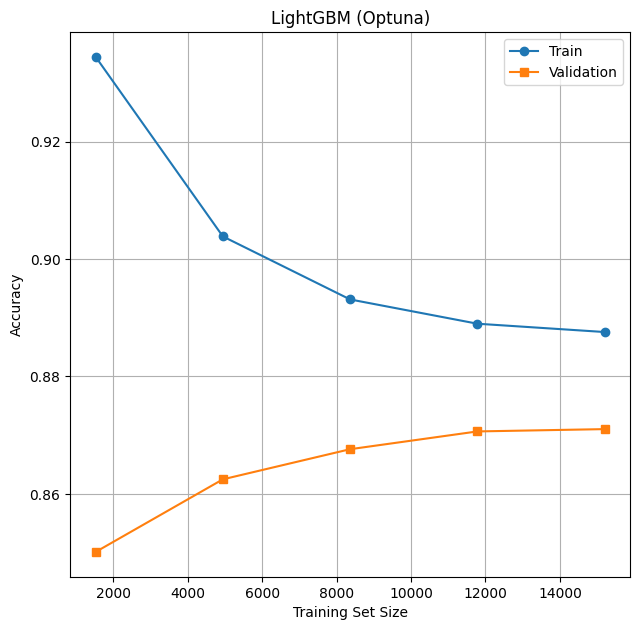

Plotting learning curve for: LightGBM


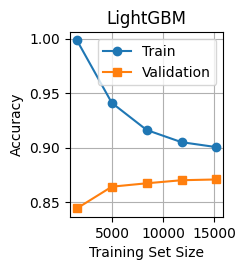

Plotting learning curve for: CatBoost


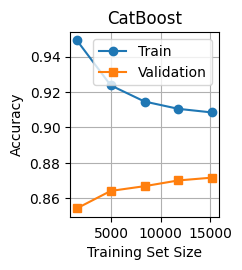

Plotting learning curve for: Voting Classifier


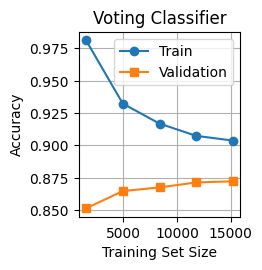

In [ ]:
from sklearn.model_selection import learning_curve


def plot_learning_curves(models_dict, X, y):
    models = {k: v for k, v in models_dict.items() if k != "Stacking Classifier"}
    plt.figure(figsize=(18, 12))

    for i, (name, model) in enumerate(models.items(), 1):
        print(f"Plotting learning curve for: {name}")
        plt.subplot(2, 3, i)
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y,
            cv=3,
            train_sizes=np.linspace(0.1, 1.0, 5),
            scoring='accuracy',
            n_jobs=-1,
            shuffle=True,
            random_state=42
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)

        plt.plot(train_sizes, train_scores_mean, label="Train", marker='o')
        plt.plot(train_sizes, val_scores_mean, label="Validation", marker='s')
        plt.title(name)
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


plot_learning_curves(models_cv, X_train_proc, y_train_enc)

####Метрики

--- LightGBM (Optuna) ---
Accuracy:  0.8729
Precision: 0.7840
Recall:    0.6514
F1-score:  0.7116
ROC AUC:   0.9234
Log Loss:  0.2868


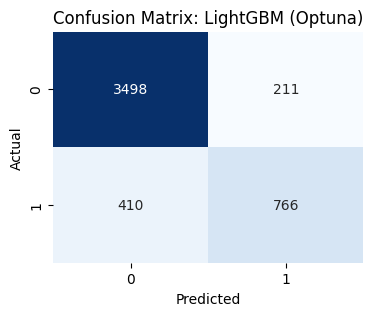

--- LightGBM ---
Accuracy:  0.8725
Precision: 0.7824
Recall:    0.6514
F1-score:  0.7109
ROC AUC:   0.9234
Log Loss:  0.2869


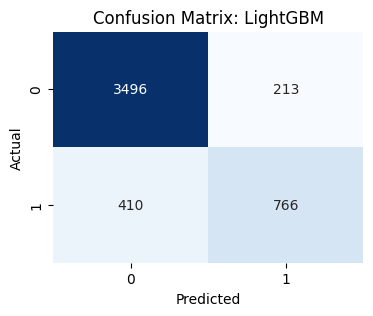

--- CatBoost ---
Accuracy:  0.8712
Precision: 0.7777
Recall:    0.6514
F1-score:  0.7089
ROC AUC:   0.9232
Log Loss:  0.2873


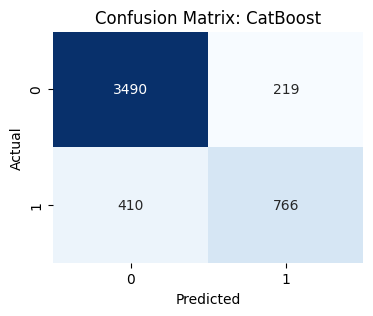

--- Stacking Classifier ---
Accuracy:  0.8712
Precision: 0.7749
Recall:    0.6556
F1-score:  0.7103
ROC AUC:   0.9214
Log Loss:  0.2931


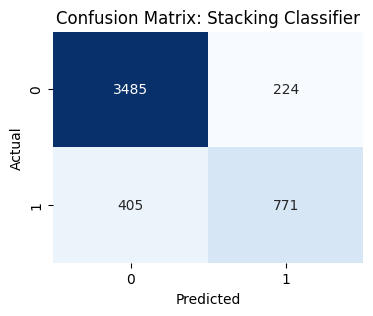

--- Voting Classifier ---
Accuracy:  0.8700
Precision: 0.7780
Recall:    0.6437
F1-score:  0.7045
ROC AUC:   0.9231
Log Loss:  0.2869


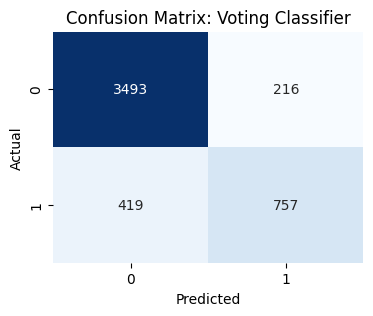

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix


def print_metrics_and_confusion_matrix(models_dict, X, y_true):
    for name, model in models_dict.items():
        # предсказания и вероятности
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

        # метрики
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
        logloss = log_loss(y_true, y_proba) if y_proba is not None else None

        print(f"--- {name} ---")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-score:  {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC:   {roc_auc:.4f}")
        if logloss is not None:
            print(f"Log Loss:  {logloss:.4f}")

        # матрица ошибок
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

print_metrics_and_confusion_matrix(models_cv, X_test_proc, y_test_enc)

##Сохранение лучшей модели

####Обучение финальной модели на лучших параметрах

In [ ]:
best_lgbm = LGBMClassifier(**study.best_trial.params)
best_lgbm.fit(X_train_proc, y_train_enc)

LGBMClassifier(colsample_bytree=0.989816083092693,
               learning_rate=0.03214566689683165, max_depth=6,
               min_child_samples=5, n_estimators=470, num_leaves=20,
               reg_alpha=2.1402332177851786, reg_lambda=3.0301461286134366,
               subsample=0.8506336536396039)

####Сохранение

In [ ]:
import joblib

joblib.dump(best_lgbm, 'lightgbm_optuna_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['lightgbm_optuna_model.pkl']

In [ ]:
pip freeze > requirements.txt

In [ ]:
import joblib